In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt

with open("C:/Users/User/Downloads/data_to_share.txt") as inp:
    tempData = [x.strip().split('\t') for x in inp]

In [2]:
data = []
for i in tempData:
    if i != ['']:
        data.append(i)

In [3]:
np.shape(data)

(19943, 4)

In [4]:
np.array([int(i[0]) for i in data])

array([  9,   9,   9, ..., 652, 652, 652])

In [5]:
x = np.array([float(i[2]) for i in data])
y = np.array([float(i[3]) for i in data])
trajectories = np.vstack((x,y)).T


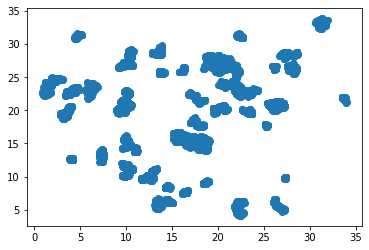

In [7]:
plt.scatter(trajectories[:,0], trajectories[:,1] )